<a href="https://colab.research.google.com/github/kristin-hub/nn/blob/master/22squeezenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Подключаем датасет с гугл диска**

In [0]:
# Most Recent One
!pip install git+https://github.com/rcmalli/keras-squeezenet.git
# Release Version
!pip install keras_squeezenet

  Cloning https://github.com/rcmalli/keras-squeezenet.git to /tmp/pip-req-build-uzisazaj
  Running command git clone -q https://github.com/rcmalli/keras-squeezenet.git /tmp/pip-req-build-uzisazaj
  Created wheel for keras-squeezenet: filename=keras_squeezenet-0.4-cp36-none-any.whl size=4424 sha256=d5d46d7c21d91ef4681e7bbca17075014dd09f038ae206d4c0d541ea36f87cdb
  Stored in directory: /tmp/pip-ephem-wheel-cache-g62h2fe4/wheels/15/75/ed/45fffbc76d921a5be07af533b774b35bbf40551334c51af91f
Successfully built keras-squeezenet


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from os import listdir, rename
from os.path import isfile, join

source_dir = 'drive/My Drive/data'
train_dir = 'drive/My Drive/data/train'
validation_dir = 'drive/My Drive/data/validation'
test_dir = 'drive/My Drive/data/test'

fake_dir = 'fake'
orig_dir = 'orig'

images = [f for f in listdir(source_dir) if isfile(join(source_dir, f))]

In [0]:
import numpy as np
import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

np.random.seed(0)
tf.set_random_seed(0)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


Using TensorFlow backend.


**Проверяем включена ли GPU**

In [0]:
train_data_dir = 'drive/My Drive/data/train'
test_data_dir = 'drive/My Drive/data/test'
validation_data_dir = 'drive/My Drive/data/validation'

img_height = 224
img_width = 224

batch_size = 16
epochs = 150

train_first_class = 4112
train_second_class = 4112

val_first_class = 1120
val_second_class = 1120

nb_train_samples = train_first_class + train_second_class
nb_validation_samples = val_first_class + val_second_class


In [0]:
!python -c "import keras; print(keras.__version__)"


Using TensorFlow backend.
2.1.1


In [0]:
!pip install q keras==2.1.1

     |████████████████████████████████| 307kB 4.0MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.1 which is incompatible.
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


**Прогоняем наш датасет через сверточные слои предобученной сети Xception, чтобы получить признаки и сохраняем их**

In [0]:
from keras.layers import Input
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.mobilenet_v2 import MobileNetV2 
#from keras.applications.mobilenetv3 import MobileNetV3

from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image



input_tensor = Input(shape=(img_height,img_width,3))

base_model = SqueezeNet(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')
'''
inc_model=InceptionV3(include_top=False,
                      weights='imagenet',
                      input_shape=((3, 150, 150)))'''


data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

Found 8224 images belonging to 2 classes.
Prediction of the training set finished.
Found 2240 images belonging to 2 classes.
Prediction of the validation set finished.


In [0]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * train_first_class + [1] * train_second_class)

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * (val_first_class) + [1] * (val_second_class))

**Создадим полносвязную сеть и обучим её на полученных признаках**

In [0]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.layers import Dropout, Dense

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))    

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))   

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=SGD(lr=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 8224 samples, validate on 2240 samples
Epoch 1/150
8224/8224 [==============================] - 6s 692us/step - loss: 0.8150 - acc: 0.5058 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 2/150
8224/8224 [==============================] - 3s 380us/step - loss: 0.6996 - acc: 0.5034 - val_loss: 0.6934 - val_acc: 0.4701
Epoch 3/150
8224/8224 [==============================] - 3s 394us/step - loss: 0.6942 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.4996
Epoch 4/150
8224/8224 [==============================] - 4s 435us/step - loss: 0.6935 - acc: 0.4979 - val_loss: 0.6933 - val_acc: 0.5058
Epoch 5/150
8224/8224 [==============================] - 3s 423us/step - loss: 0.6935 - acc: 0.4863 - val_loss: 0.6931 - val_acc: 0.4996
Epoch 6/150
8224/8224 [==============================] - 3s 423us/step - loss: 0.6932 - acc: 0.4978 - val_loss: 0.6931 - val_acc: 0.4996
Epoch 7/150
8224/8224 [==============================] - 3s 407us/step - loss: 0.6932 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 

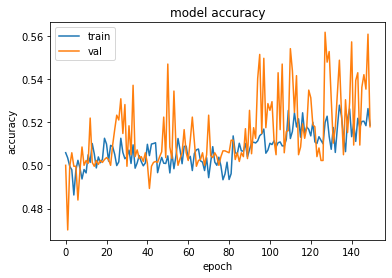

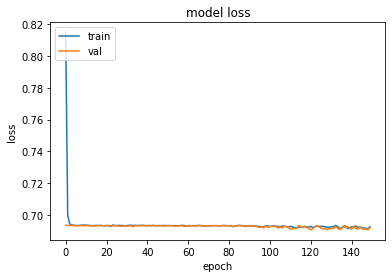

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Объединяем сверточную и полносвязную сеть**

In [0]:
from keras.models import Model

batch_size = 16
epochs = 50

input_tensor = Input(shape=(img_height,img_width,3))

base_model = SqueezeNet(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(512, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))  

top_model.add(Dense(64, activation='relu'))
top_model.add(Dropout(0.5))  

top_model.add(Dense(1, activation='sigmoid'))

top_model.load_weights('top-weights.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='binary_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 8224 images belonging to 2 classes.
Found 2240 images belonging to 2 classes.
Epoch 1/50
514/514 [==============================] - 167s 325ms/step - loss: 0.6936 - acc: 0.5078 - val_loss: 0.6934 - val_acc: 0.5022
Epoch 2/50
514/514 [==============================] - 161s 314ms/step - loss: 0.6943 - acc: 0.5013 - val_loss: 0.6914 - val_acc: 0.5540
Epoch 3/50
514/514 [==============================] - 159s 309ms/step - loss: 0.6937 - acc: 0.5018 - val_loss: 0.6921 - val_acc: 0.5170
Epoch 4/50
514/514 [==============================] - 158s 307ms/step - loss: 0.6931 - acc: 0.5168 - val_loss: 0.6932 - val_acc: 0.5018
Epoch 5/50
514/514 [==============================] - 156s 304ms/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.5045
Epoch 6/50
514/514 [==============================] - 157s 305ms/step - loss: 0.6937 - acc: 0.5038 - val_loss: 0.6928 - val_acc: 0.5232
Epoch 7/50
514/514 [==============================] - 156s 303ms/step - loss: 0.6933 - acc: 0.5068 -

**Тестируем полученную сеть**

In [0]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])

Found 2401 images belonging to 2 classes.
Loss:  0.6386033137457314 Accuracy:  0.6438983756768013


**Сохраняем лучшие веса сети**

In [0]:
model.save('fake_orig_squeezenet_v1.h5')